# Gaussian Mixture Model

This tutorial demonstrates how to marginalize out discrete latent variables in NumPyro through the motivating example of a mixture model. We'll focus on the mechanics of parallel enumeration, keeping the model simple by training a trivial 1-D Gaussian model on a tiny 5-point dataset. See also the [enumeration tutorial](http://pyro.ai/examples/enumeration.html) for a broader introduction to parallel enumeration.

#### Table of contents

- [Overview](#Overview)
- [Training a MAP estimator](#Training-a-MAP-estimator)
- [Serving the model: predicting membership](#Serving-the-model:-predicting-membership)
  - [Predicting membership using discrete inference](#Predicting-membership-using-discrete-inference)
  - [Predicting membership by enumerating in the guide](#Predicting-membership-by-enumerating-in-the-guide)
- [MCMC](#MCMC)

In [ ]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro

In [1]:
from collections import defaultdict
import os

import matplotlib.pyplot as plt
import scipy.stats

from jax import pure_callback, random
import jax.numpy as jnp
import optax

import numpyro
from numpyro import handlers
from numpyro.contrib.funsor import config_enumerate, infer_discrete
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer import SVI, TraceEnum_ELBO, init_to_value
from numpyro.infer.autoguide import AutoDelta

%matplotlib inline

smoke_test = "CI" in os.environ
assert numpyro.__version__.startswith("0.17.0")

## Overview

NumPyro's [TraceEnum_ELBO](https://num.pyro.ai/en/latest/svi.html#numpyro.infer.elbo.TraceEnum_ELBO) can automatically marginalize out variables in both the guide and the model. When enumerating guide variables, NumPyro enumerates in parallel by allocating on the left a new array dimension and using nonstandard evaluation to create an array of possible values at the variable's sample site. These nonstandard values are then replayed in the model. When enumerating variables in the model, the variables are enumerated in parallel and must not appear in the guide. Mathematically, guide-side enumeration simply reduces variance in stochastic ELBO estimates by exactly integrating out  an enumerated variable, whereas model-side enumeration avoids an application of Jensen's inequality by exactly marginalizing out an enumerated variable.
 
Here is our tiny dataset. It has five points.

In [2]:
data = jnp.array([0.0, 1.0, 10.0, 11.0, 12.0])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Training a MAP estimator

Let's start by learning model parameters `weights`, `locs`, and `scale` given priors and data. We will learn point estimates of these using an [AutoDelta](https://num.pyro.ai/en/latest/autoguide.html#numpyro.infer.autoguide.AutoDelta) guide (named after its delta distributions). Our model will learn global mixture weights, the location of each mixture component, and a shared scale that is common to both components. During inference, [TraceEnum_ELBO](https://num.pyro.ai/en/latest/svi.html#numpyro.infer.elbo.TraceEnum_ELBO) will marginalize out the assignments of datapoints to clusters.

In [3]:
K = 2  # Fixed number of components.


@config_enumerate
def model(data):
    # Global variables.
    weights = numpyro.sample("weights", dist.Dirichlet(0.5 * jnp.ones(K)))
    scale = numpyro.sample("scale", dist.LogNormal(0.0, 2.0))
    with numpyro.plate("components", K):
        locs = numpyro.sample("locs", dist.Normal(0.0, 10.0))

    with numpyro.plate("data", len(data)):
        # Local variables.
        assignment = numpyro.sample("assignment", dist.Categorical(weights))
        numpyro.sample("obs", dist.Normal(locs[assignment], scale), obs=data)

To run inference with this `(model,guide)` pair, we use NumPyro's [config_enumerate](https://num.pyro.ai/en/stable/funsor.html#numpyro.contrib.funsor.infer_util.config_enumerate) handler to enumerate over all assignments in each iteration. Since we've wrapped the batched Categorical assignments in a [numpyro.plate](https://num.pyro.ai/en/stable/primitives.html#numpyro.primitives.plate) independence context along the `data` batch dimension, this enumeration can happen in parallel: we enumerate only 2 possibilites, rather than `2**len(data) = 32`.

Before inference we'll initialize to plausible values. Mixture models are very susceptible to local modes. A common approach is to choose the best among many random initializations, where the cluster means are initialized from random subsamples of the data. Since we're using an [AutoDelta](https://num.pyro.ai/en/latest/autoguide.html#numpyro.infer.autoguide.AutoDelta) guide, we can initialize by using a [init_to_value](https://num.pyro.ai/en/stable/utilities.html#numpyro.infer.initialization.init_to_value) helper function.

In [4]:
elbo = TraceEnum_ELBO()


def initialize(seed):
    global global_guide
    init_values = {
        "weights": jnp.ones(K) / K,
        "scale": jnp.sqrt(data.var() / 2),
        "locs": data[
            random.categorical(
                random.PRNGKey(seed), jnp.ones(len(data)) / len(data), shape=(K,)
            )
        ],
    }
    global_model = handlers.block(
        handlers.seed(model, random.PRNGKey(0)),
        hide_fn=lambda site: site["name"]
        not in ["weights", "scale", "locs", "components"],
    )
    global_guide = AutoDelta(
        global_model, init_loc_fn=init_to_value(values=init_values)
    )
    handlers.seed(global_guide, random.PRNGKey(0))(data)  # warm up the guide
    return elbo.loss(random.PRNGKey(0), {}, model, global_guide, data)


# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)  # initialize the global_guide
print(f"seed = {seed}, initial_loss = {loss}")

seed = 8, initial_loss = 25.149845123291016


During training, we’ll collect both losses and gradient norms to monitor convergence. We can do this using `hook_optax` helper function below.

In [5]:
# Helper function to collect gradient norms during training
def hook_optax(optimizer):
    gradient_norms = defaultdict(list)

    def append_grad(grad):
        for name, g in grad.items():
            gradient_norms[name].append(float(jnp.linalg.norm(g)))
        return grad

    def update_fn(grads, state, params=None):
        grads = pure_callback(append_grad, grads, grads)
        return optimizer.update(grads, state, params=params)

    return optax.GradientTransformation(optimizer.init, update_fn), gradient_norms


optim, gradient_norms = hook_optax(optax.adam(learning_rate=0.1, b1=0.8, b2=0.99))
global_svi = SVI(model, global_guide, optim, loss=elbo)

Now train the model:

In [6]:
global_svi_result = global_svi.run(
    random.PRNGKey(0), 200 if not smoke_test else 2, data
)

100%|███████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 287.42it/s, init loss: 25.1498, avg. loss [191-200]: 17.4433]


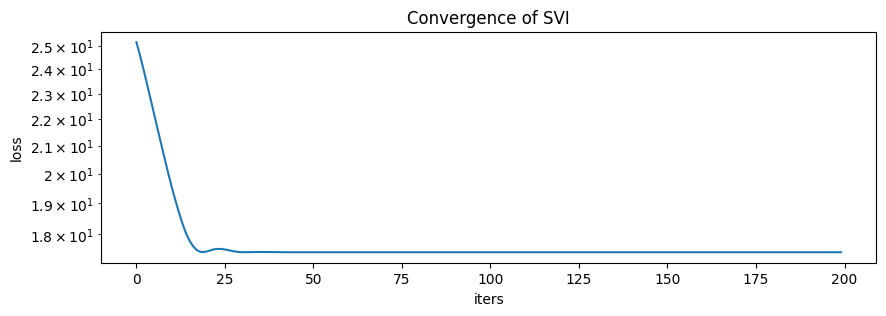

In [7]:
plt.figure(figsize=(10, 3), dpi=100).set_facecolor("white")
plt.plot(global_svi_result.losses)
plt.xlabel("iters")
plt.ylabel("loss")
plt.yscale("log")
plt.title("Convergence of SVI")
plt.show()

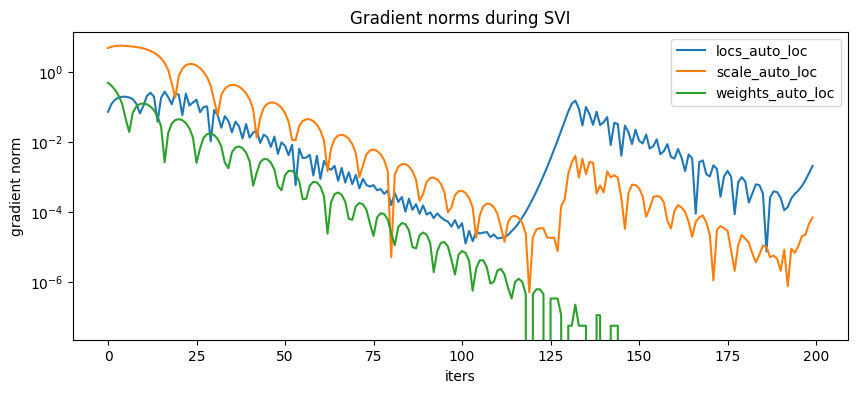

In [8]:
plt.figure(figsize=(10, 4), dpi=100).set_facecolor("white")
for name, grad_norms in gradient_norms.items():
    plt.plot(grad_norms, label=name)
plt.xlabel("iters")
plt.ylabel("gradient norm")
plt.yscale("log")
plt.legend(loc="best")
plt.title("Gradient norms during SVI")
plt.show()

Here are the learned parameters:

In [9]:
map_estimates = global_svi_result.params
weights = map_estimates["weights_auto_loc"]
locs = map_estimates["locs_auto_loc"]
scale = map_estimates["scale_auto_loc"]
print(f"weights = {weights}")
print(f"locs = {locs}")
print(f"scale = {scale}")

weights = [0.375 0.625]
locs = [ 0.4989534 10.984944 ]
scale = 0.6514341831207275


The model's `weights` are as expected, with about 2/5 of the data in the first component and 3/5 in the second component. Next let's visualize the mixture model.

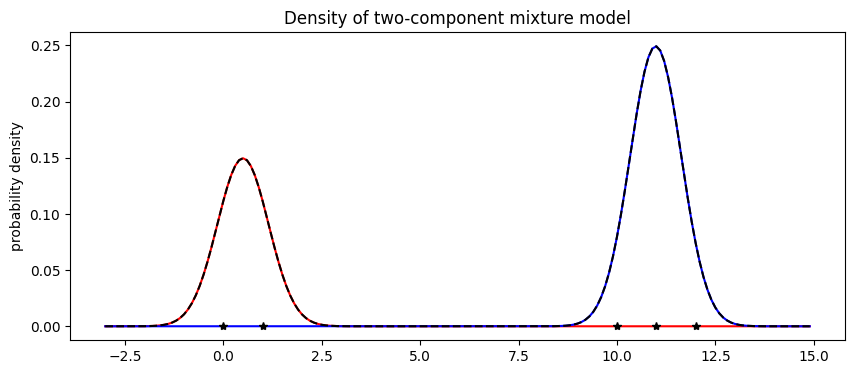

In [10]:
X = jnp.arange(-3, 15, 0.1)
Y1 = weights[0] * scipy.stats.norm.pdf((X - locs[0]) / scale)
Y2 = weights[1] * scipy.stats.norm.pdf((X - locs[1]) / scale)

plt.figure(figsize=(10, 4), dpi=100).set_facecolor("white")
plt.plot(X, Y1, "r-")
plt.plot(X, Y2, "b-")
plt.plot(X, Y1 + Y2, "k--")
plt.plot(data, jnp.zeros(len(data)), "k*")
plt.title("Density of two-component mixture model")
plt.ylabel("probability density")
plt.show()

Finally note that optimization with mixture models is non-convex and can often get stuck in local optima. For example in this tutorial, we observed that the mixture model gets stuck in an everthing-in-one-cluster hypothesis if `scale` is initialized to be too large.

## Serving the model: predicting membership

Now that we've trained a mixture model, we might want to use the model as a classifier. 
During training we marginalized out the assignment variables in the model. While this provides fast convergence, it prevents us from reading the cluster assignments from the guide. We'll discuss two options for treating the model as a classifier: first using [infer_discrete](https://num.pyro.ai/en/stable/funsor.html#numpyro.contrib.funsor.discrete.infer_discrete) (much faster) and second by training a secondary guide using enumeration inside SVI (slower but more general).

### Predicting membership using discrete inference

The fastest way to predict membership is to use the [infer_discrete](https://num.pyro.ai/en/stable/funsor.html#numpyro.contrib.funsor.discrete.infer_discrete) handler, together with `trace` and `replay`. Let's start out with a MAP classifier, setting `infer_discrete`'s temperature parameter to zero. For a deeper look at effect handlers like `trace`, `replay`, and `infer_discrete`, see the [effect handler tutorial](http://pyro.ai/examples/effect_handlers.html).

In [11]:
trained_global_guide = handlers.substitute(
    global_guide, global_svi_result.params
)  # substitute trained params
guide_trace = handlers.trace(trained_global_guide).get_trace(data)  # record the globals
trained_model = handlers.replay(model, trace=guide_trace)  # replay the globals


def classifier(data, temperature=0, rng_key=None):
    inferred_model = infer_discrete(
        trained_model, temperature=temperature, first_available_dim=-2, rng_key=rng_key
    )  # set first_available_dim to avoid conflict with data plate
    seeded_inferred_model = handlers.seed(inferred_model, random.PRNGKey(0))
    trace = handlers.trace(seeded_inferred_model).get_trace(data)
    return trace["assignment"]["value"]


print(classifier(data))

[0 0 1 1 1]


Indeed we can run this classifer on new data

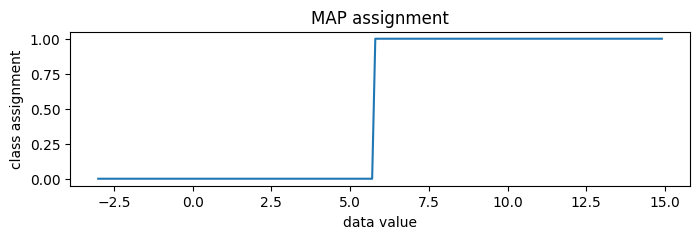

In [12]:
new_data = jnp.arange(-3, 15, 0.1)
assignment = classifier(new_data)
plt.figure(figsize=(8, 2), dpi=100).set_facecolor("white")
plt.plot(new_data, assignment)
plt.title("MAP assignment")
plt.xlabel("data value")
plt.ylabel("class assignment")
plt.show()

To generate random posterior assignments rather than MAP assignments, we could set `temperature=1`.

In [13]:
print(classifier(data, temperature=1, rng_key=random.PRNGKey(0)))

[0 0 1 1 1]


Since the classes are very well separated, we zoom in to the boundary between classes, around 5.75.

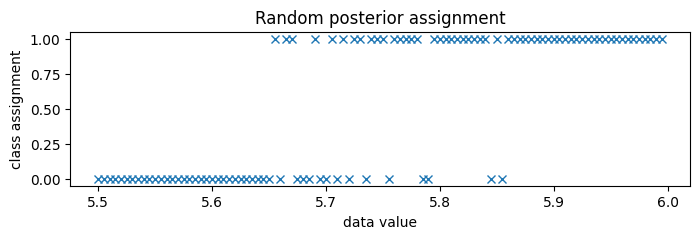

In [14]:
new_data = jnp.arange(5.5, 6.0, 0.005)
assignment = classifier(new_data, temperature=1, rng_key=random.PRNGKey(0))
plt.figure(figsize=(8, 2), dpi=100).set_facecolor("white")
plt.plot(new_data, assignment, "x", color="C0")
plt.title("Random posterior assignment")
plt.xlabel("data value")
plt.ylabel("class assignment")
plt.show()

### Predicting membership by enumerating in the guide

A second way to predict class membership is to enumerate in the guide. This doesn't work well for serving classifier models, since we need to run stochastic optimization for each new input data batch, but it is more general in that it can be embedded in larger variational models.

To read cluster assignments from the guide, we'll define a new `full_guide` that fits both global parameters (as above) and local parameters (which were previously marginalized out). Since we've already learned good values for the global variables, we will block SVI from updating those by using [handlers.block](https://num.pyro.ai/en/stable/handlers.html#numpyro.handlers.block).

In [15]:
@config_enumerate
def full_guide(data):
    # Global variables.
    with handlers.block(
        hide=["weights_auto_loc", "locs_auto_loc", "scale_auto_loc"]
    ):  # Keep our learned values of global parameters.
        trained_global_guide(data)

    # Local variables.
    with numpyro.plate("data", len(data)):
        assignment_probs = numpyro.param(
            "assignment_probs",
            jnp.ones((len(data), K)) / K,
            constraint=constraints.simplex,
        )
        numpyro.sample("assignment", dist.Categorical(assignment_probs))

In [16]:
optim, gradient_norms = hook_optax(optax.adam(learning_rate=0.2, b1=0.8, b2=0.99))
elbo = TraceEnum_ELBO()
full_svi = SVI(model, full_guide, optim, loss=elbo)


full_svi_result = full_svi.run(random.PRNGKey(0), 200 if not smoke_test else 2, data)

100%|██████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 298.62it/s, init loss: 338.6479, avg. loss [191-200]: 18.2659]


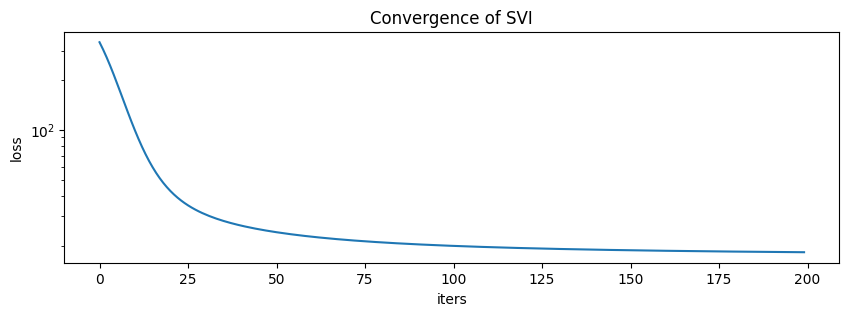

In [17]:
plt.figure(figsize=(10, 3), dpi=100).set_facecolor("white")
plt.plot(full_svi_result.losses)
plt.xlabel("iters")
plt.ylabel("loss")
plt.yscale("log")
plt.title("Convergence of SVI")
plt.show()

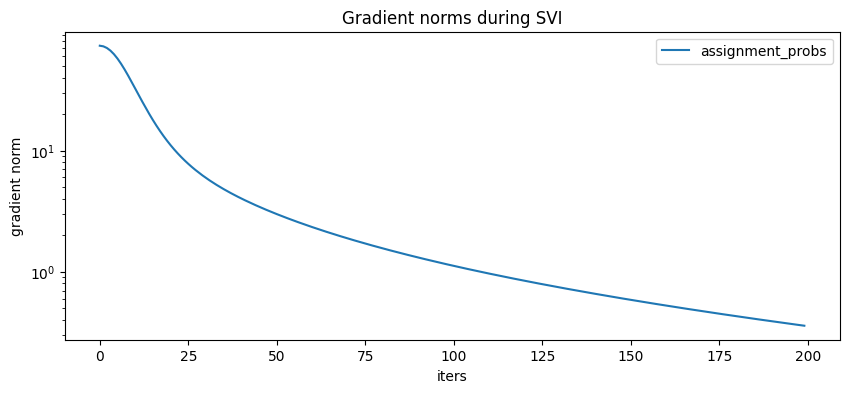

In [18]:
plt.figure(figsize=(10, 4), dpi=100).set_facecolor("white")
for name, grad_norms in gradient_norms.items():
    plt.plot(grad_norms, label=name)
plt.xlabel("iters")
plt.ylabel("gradient norm")
plt.yscale("log")
plt.legend(loc="best")
plt.title("Gradient norms during SVI")
plt.show()

We can now examine the guide's local `assignment_probs` variable.

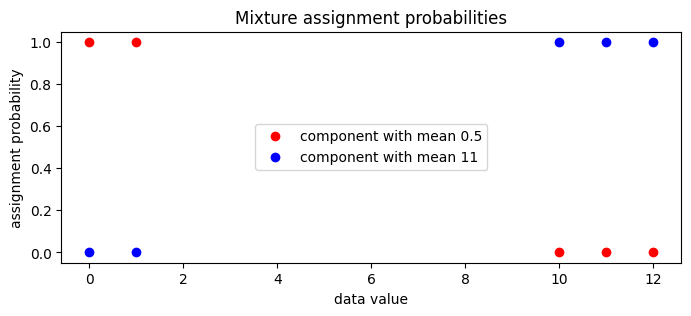

In [19]:
assignment_probs = full_svi_result.params["assignment_probs"]
plt.figure(figsize=(8, 3), dpi=100).set_facecolor("white")
plt.plot(
    data,
    assignment_probs[:, 0],
    "ro",
    label=f"component with mean {locs[0]:0.2g}",
)
plt.plot(
    data,
    assignment_probs[:, 1],
    "bo",
    label=f"component with mean {locs[1]:0.2g}",
)
plt.title("Mixture assignment probabilities")
plt.xlabel("data value")
plt.ylabel("assignment probability")
plt.legend(loc="center")
plt.show()

## MCMC

Next we'll explore the full posterior over component parameters using collapsed NUTS, i.e. we'll use NUTS and marginalize out all discrete latent variables.

In [20]:
from numpyro.infer import MCMC, NUTS

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=50, num_samples=250)
mcmc.run(random.PRNGKey(2), data)
mcmc.print_summary()
posterior_samples = mcmc.get_samples()

sample: 100%|███████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 130.21it/s, 7 steps of size 2.44e-01. acc. prob=0.41]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   locs[0]      2.45      4.30      0.62     -0.97     11.41      8.92      1.14
   locs[1]      8.72      4.19     10.75      0.23     11.78      8.12      1.16
     scale      1.58      1.75      1.02      0.57      3.46     19.19      1.02
weights[0]      0.47      0.20      0.48      0.17      0.76      8.78      1.03
weights[1]      0.53      0.20      0.52      0.24      0.83      8.78      1.03

Number of divergences: 11


In [21]:
X, Y = posterior_samples["locs"].T

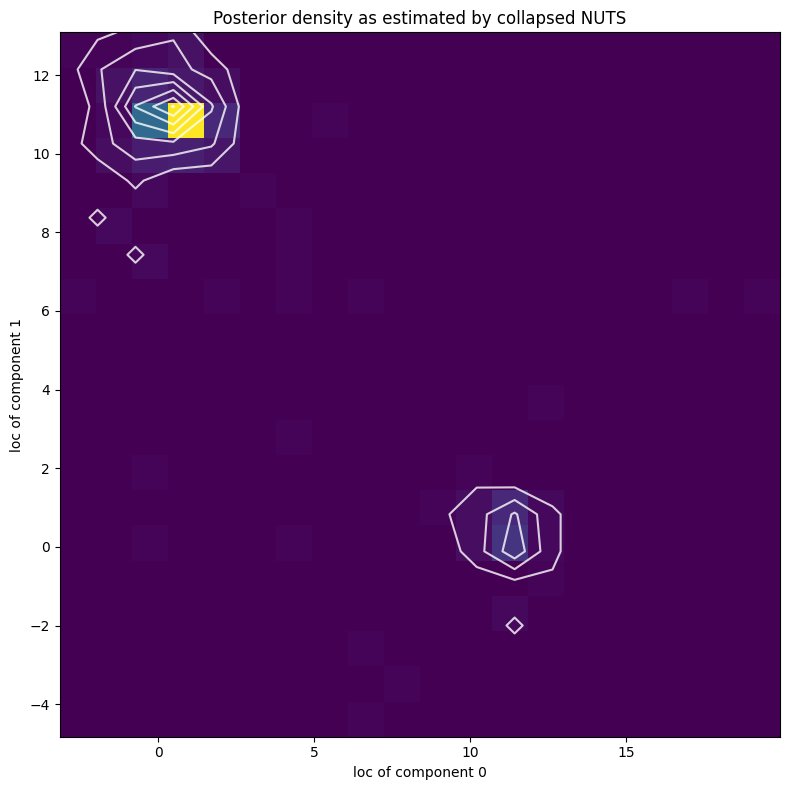

In [22]:
plt.figure(figsize=(8, 8), dpi=100).set_facecolor("white")
h, xs, ys, image = plt.hist2d(X, Y, bins=[20, 20])
plt.contour(
    jnp.log(h + 3).T,
    extent=[xs.min(), xs.max(), ys.min(), ys.max()],
    colors="white",
    alpha=0.8,
)
plt.title("Posterior density as estimated by collapsed NUTS")
plt.xlabel("loc of component 0")
plt.ylabel("loc of component 1")
plt.tight_layout()
plt.show()

Note that due to nonidentifiability of the mixture components the likelihood landscape has two equally likely modes, near `(11,0.5)` and `(0.5,11)`. NUTS has difficulty switching between the two modes.

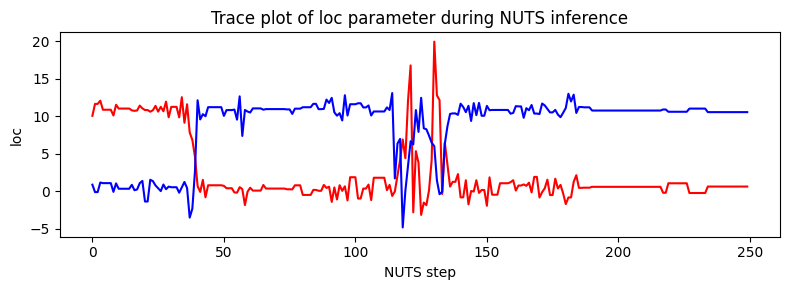

In [23]:
plt.figure(figsize=(8, 3), dpi=100).set_facecolor("white")
plt.plot(X, color="red")
plt.plot(Y, color="blue")
plt.xlabel("NUTS step")
plt.ylabel("loc")
plt.title("Trace plot of loc parameter during NUTS inference")
plt.tight_layout()
plt.show()